In [19]:
import numpy as np 
import pandas as pd 
import json 
from tqdm import tqdm 
from pprint import pprint 
import os
import matplotlib.pyplot as plt
from pprint import pprint
import glob
import shutil
import cv2

In [20]:
dataset_path = "/kaggle/input/pklot-dataset"

In [21]:
train_dir = '/kaggle/input/pklot-dataset/train'
test_dir = '/kaggle/input/pklot-dataset/test'
val_dir = '/kaggle/input/pklot-dataset/valid'
output_path = "/kaggle/working/dataset"
os.makedirs(output_path, exist_ok = True)

In [22]:
def get_json_file(directory):
    json_files = glob.glob(os.path.join(directory, '**', '*.json'), recursive=True)
    return str(json_files[0]) if json_files else None

In [111]:
anno_train = get_json_file(train_dir)
anno_val = get_json_file(val_dir)
anno_test = get_json_file(test_dir)

In [24]:
with open(anno_train, "r") as file:
    data = json.load(file)

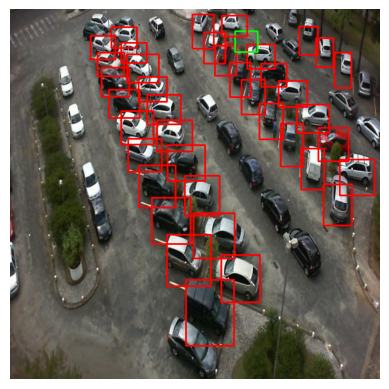

In [26]:
for image_info in data['images']:
    image_id = image_info['id']
    image_path = os.path.join(train_dir, image_info['file_name'])
    
    image = cv2.imread(image_path)
    if image is None:
        continue
    
    for annotation in data['annotations']:
        if annotation['image_id'] == image_id: 
            category_id = annotation['category_id']
            bbox = annotation['bbox']
            x, y, w, h = map(int, bbox)
            
            color = (0, 255, 0) if category_id == 1 else (0, 0, 255) if category_id == 2 else (255, 0, 0)
            
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    break


# Load Annotation

In [128]:
def load_coco_annotations(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    annotations = {}
#     pprint(data['images'][0])
    image_info = {image['id']: image['file_name'] for image in data['images']} 
#     pprint(image_info)

    for annotation in data['annotations']:
        image_id = annotation['image_id']
        
        filter_annotation = {
            'category_id': annotation['category_id'],
            'bbox': annotation['bbox']
        }
        
        if image_id not in annotations:
            annotations[image_id] = {'file_name': image_info[image_id], 'annotations': []}
        
        annotations[image_id]['annotations'].append(filter_annotation)
    return annotations

# format annotation yolo

In [28]:
def save_yolo_annotation(annotation, output_annotation_path, image_width, image_height):
    with open(output_annotation_path, "w") as file:
        for index, data_anno in enumerate(annotation):
            bbox = data_anno['bbox']
            x_min = bbox[0]
            y_min = bbox[1]
            width = bbox[2]
            height = bbox[3]
            
            x_center = (x_min + width / 2) / image_width
            y_center = (y_min + height / 2) / image_height
            width /= image_width
            height /= image_height
            
            label_num = 0 if data_anno["category_id"] == 1 else 1 
            file.write(f"{label_num} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


In [29]:
images_folder = os.path.join(output_path, "images")
labels_folder = os.path.join(output_path, "labels")
os.makedirs(images_folder, exist_ok=True)
os.makedirs(labels_folder, exist_ok=True)

train_images_folder = os.path.join(images_folder, "train")
val_images_folder = os.path.join(images_folder, "val")
test_images_folder = os.path.join(images_folder, "test")

train_labels_folder = os.path.join(labels_folder, "train")
val_labels_folder = os.path.join(labels_folder, "val")
test_labels_folder = os.path.join(labels_folder, "test")

os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(val_images_folder, exist_ok=True)
os.makedirs(test_images_folder, exist_ok=True)

os.makedirs(train_labels_folder, exist_ok=True)
os.makedirs(val_labels_folder, exist_ok=True)
os.makedirs(test_labels_folder, exist_ok=True)

In [129]:
data_train = load_coco_annotations(anno_train)

In [132]:
from itertools import islice
def process_and_save_images(input_image_dir, annotations, images_folder, labels_folder):
#     first_10_annotations = dict(islice(annotations.items(), 1))
#     pprint(first_10_annotations)
    a = 0
    for image_id, image_data in tqdm(annotations.items(), desc="Processing Images"):
        file_name = image_data['file_name']
        print(image_id)
        if image_id == a:
            a = a + 1
        else:
            print(f"error: {image_id}")
        image_path = os.path.join(input_image_dir, file_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error reading image {image_path}")
            continue

        output_image_path = os.path.join(images_folder, f"{image_id}.jpg")
        cv2.imwrite(output_image_path, image)

        output_annotation_path = os.path.join(labels_folder, f"{image_id}.txt")
        save_yolo_annotation(image_data['annotations'], output_annotation_path, image.shape[0], image.shape[1])


In [106]:
def process_data(anno_path, image_dir, train_images_folder, train_labels_folder):
    annotations = load_coco_annotations(anno_path)
    process_and_save_images(image_dir, annotations, train_images_folder, train_labels_folder)

In [ ]:
process_data(anno_train, train_dir, train_images_folder, train_labels_folder)
process_data(anno_val, val_dir, val_images_folder, val_labels_folder)
process_data(anno_test, test_dir, test_images_folder, test_labels_folder)

# Check catagory: "spaces"

In [ ]:
with open(anno_train, "r") as file:
    data = json.load(file)

spaces_id = 0

images_with_spaces = set()
for annotation in data['annotations']:
    if annotation['category_id'] == spaces_id:
        images_with_spaces.add(annotation['image_id'])

images_info = [img for img in data['images'] if img['id'] in images_with_spaces]

print("Các ảnh có chứa nhãn 'spaces':")
for image_info in images_info:
    print(f"Image ID: {image_info['id']}, File Name: {image_info['file_name']}")


In [ ]:
# def clean_all_output(output_path):
#     if os.path.exists(output_path):
#         for item in os.listdir(output_path):
#             item_path = os.path.join(output_path, item)
#             if os.path.isdir(item_path):
#                 shutil.rmtree(item_path)
#             else:
#                 os.remove(item_path)
#         print(f"Tất cả nội dung trong '{output_path}' đã được xóa.")
#     else:
#         print(f"Thư mục '{output_path}' không tồn tại.")

# output_path = "/kaggle/working/" 
# clean_all_output(output_path)